<a href="https://colab.research.google.com/github/uray03/repo-airdrop/blob/main/JejakBatikModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import Model
import os
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [ ]:
# Path dan parameter
ZIP_PATH = "/content/Dataset.zip"
EXTRACT_PATH = "/content/DATASET"
TRAIN_DIR = "/content/DATASET/train"
TEST_DIR = "/content/DATASET/test"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS_INITIAL = 25
EPOCHS_FINE_TUNE = 10

In [ ]:
# Extract the dataset
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)


In [ ]:
# Data Generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

# Training and validation generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 520 images belonging to 20 classes.
Found 120 images belonging to 20 classes.
Found 160 images belonging to 20 classes.


In [ ]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Adding dropout layer
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

# Creating the full model
model = Model(inputs=base_model.input, outputs=output_layer)

# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_generator,
    epochs=EPOCHS_INITIAL,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0531 - loss: 3.6755 - val_accuracy: 0.1250 - val_loss: 2.6560 - learning_rate: 0.0010
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.2077 - loss: 2.7826 - val_accuracy: 0.3833 - val_loss: 1.9715 - learning_rate: 0.0010
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.3066 - loss: 2.3399 - val_accuracy: 0.5083 - val_loss: 1.5953 - learning_rate: 0.0010
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 276ms/step - accuracy: 0.4521 - loss: 1.8500 - val_accuracy: 0.5417 - val_loss: 1.5116 - learning_rate: 0.0010
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 374ms/step - accuracy: 0.5593 - loss: 1.5085 - val_accuracy: 0.6083 - val_loss: 1.3108 - learning_rate: 0.0010
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.5561 - loss: 1.4603 - val_accuracy: 0.5583 - val_loss: 1.2507 - learning_rate: 0.0010
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step - accuracy: 0.6393 - loss: 1.2366 - val_accura

In [ ]:
# Unfreeze all layers for fine-tuning
for layer in base_model.layers[-50:]:  # Adjust number of layers to fine-tune
    layer.trainable = True

# Compile again
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
history_fine_tune = model.fit(
    train_generator,
    epochs=EPOCHS_FINE_TUNE,
    validation_data=validation_generator,
    callbacks=[lr_scheduler]
)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5937 - loss: 1.2867 - val_accuracy: 0.4000 - val_loss: 2.9542 - learning_rate: 0.0010
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 367ms/step - accuracy: 0.8384 - loss: 0.5665 - val_accuracy: 0.2917 - val_loss: 4.9011 - learning_rate: 0.0010
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.8692 - loss: 0.3702 - val_accuracy: 0.3417 - val_loss: 6.6866 - learning_rate: 0.0010
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 292ms/step - accuracy: 0.9294 - loss: 0.2166 - val_accuracy: 0.3750 - val_loss: 6.2582 - learning_rate: 0.0010
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 358ms/step - accuracy: 0.9364 - loss: 0.2062 - val_accuracy: 0.3750 - val_loss: 6.0097 - learning_rate: 5.0000e-04
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.9691 - loss: 0.0908 - val_accuracy: 0.4167 - val_loss: 5.6732 - learning_rate: 5.0000e-04
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 281ms/step - accuracy: 0.9793 - loss: 0

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss:.3f}, Test accuracy: {test_accuracy:.2%}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5278 - loss: 4.6240
Test loss: 5.839, Test accuracy: 46.88%


In [ ]:
# Predict on the test data
predictions = model.predict(test_generator)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Get true and predicted class indices
true_class_indices = test_generator.classes
predicted_class_indices = np.argmax(predictions, axis=1)

# Map predicted class indices to class labels
predicted_labels = [class_labels[idx] for idx in predicted_class_indices]

# Calculate prediction confidence for each image
prediction_confidences = np.max(predictions, axis=1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step


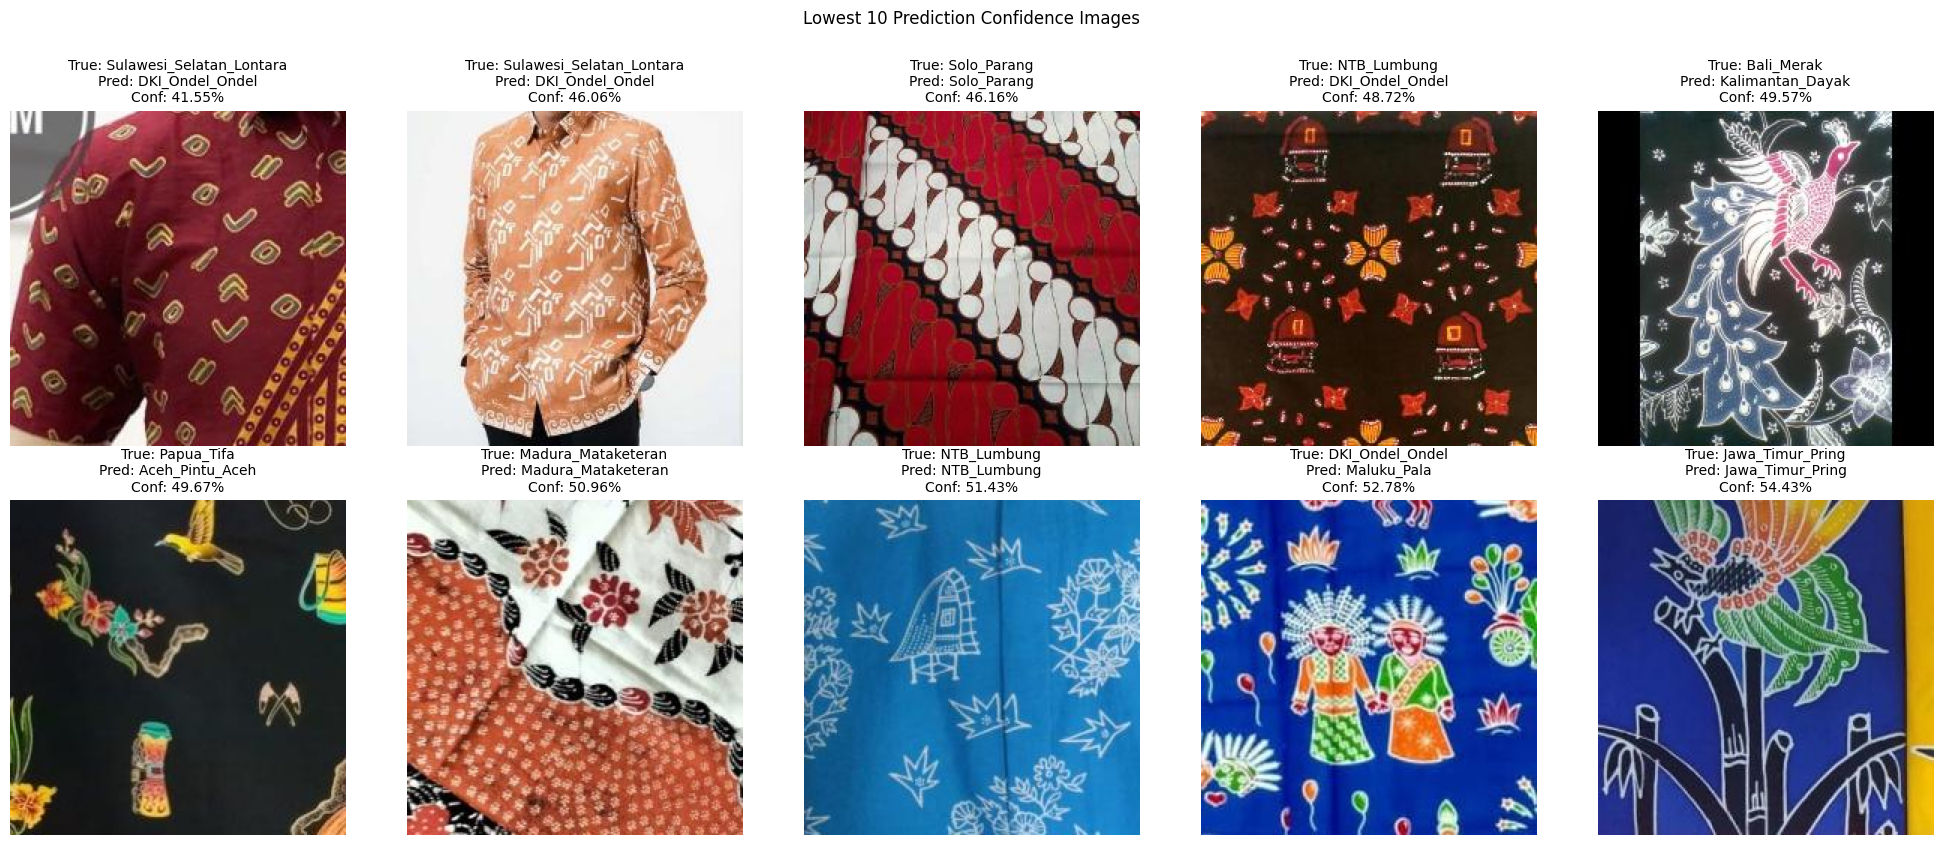

In [ ]:
# Displaying the lowest 10 predictions
low_conf_indices = np.argsort(prediction_confidences)[:10]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(low_conf_indices):
    img_path = test_generator.filepaths[idx]
    true_label = class_labels[true_class_indices[idx]]
    predicted_label = predicted_labels[idx]
    confidence = prediction_confidences[idx] * 100

    img = plt.imread(img_path)
    ax = axes[i // 5, i % 5]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=10)

plt.tight_layout()
plt.suptitle('Lowest 10 Prediction Confidence Images', y=1.05)
plt.show()


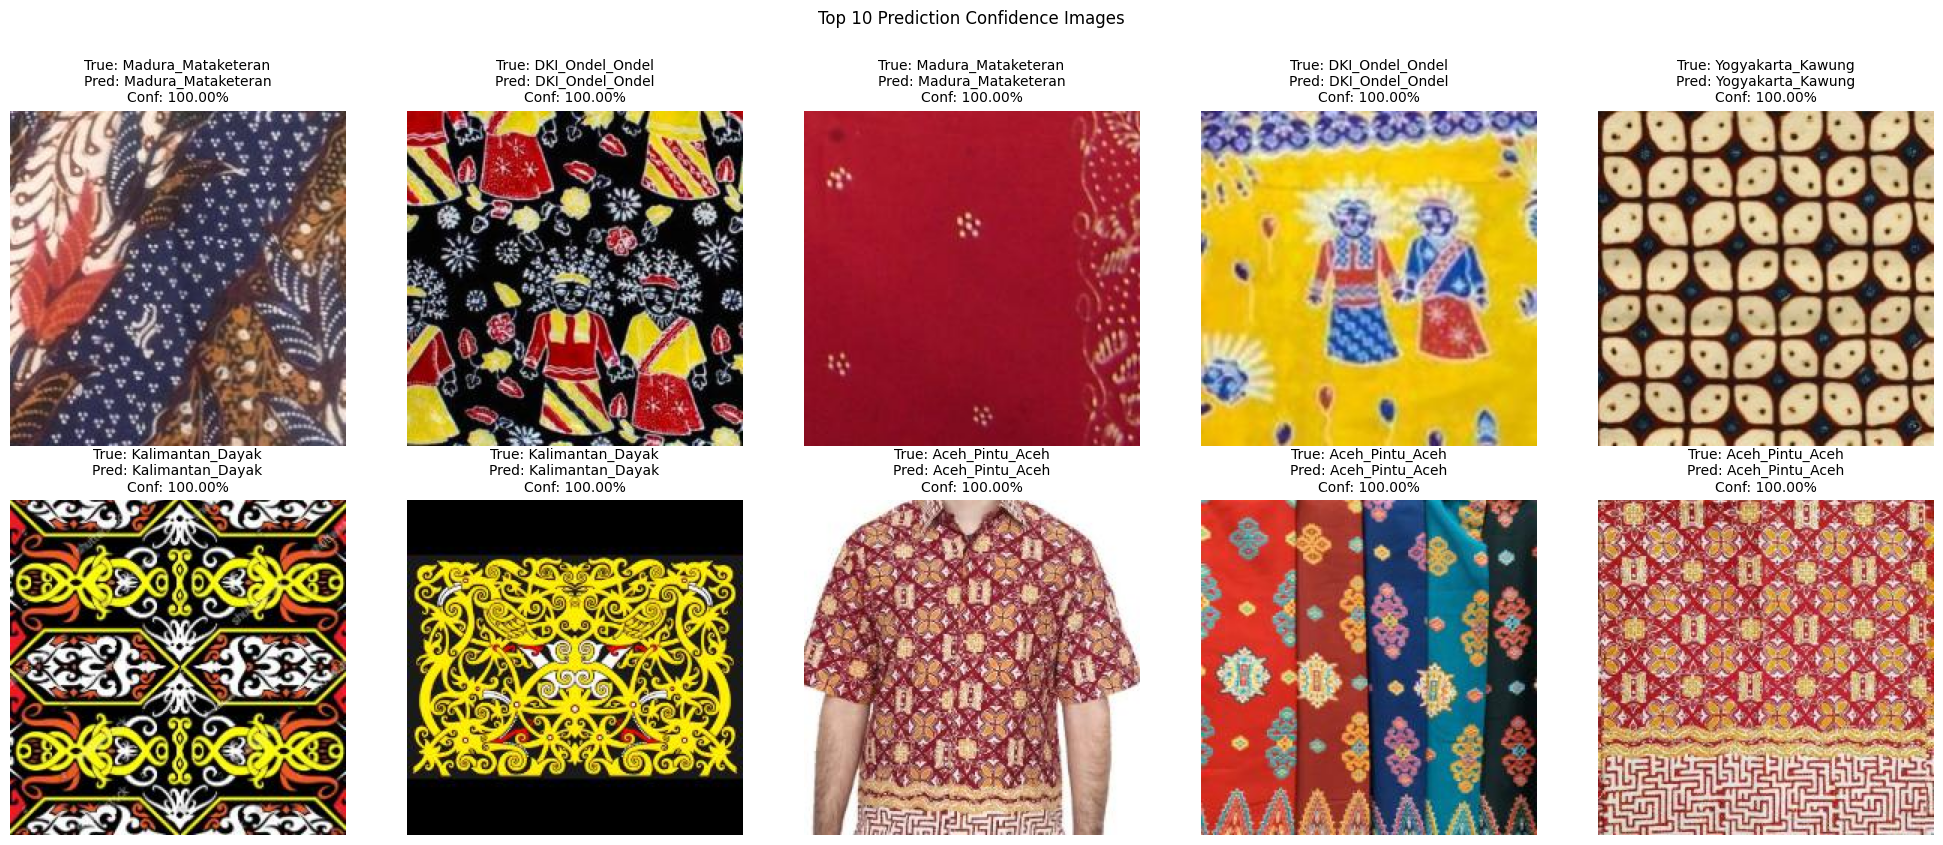

In [ ]:
# Get the indices of the top 10 highest confidence predictions
top_10_indices = np.argsort(prediction_confidences)[-10:][::-1]  # Sort and get top 10

# Plotting top 10 predictions with highest confidence
images_per_row = 5
fig, axes = plt.subplots(2, images_per_row, figsize=(20, 8))

for i, idx in enumerate(top_10_indices):
    img_path = test_generator.filepaths[idx]
    true_label = class_labels[true_class_indices[idx]]
    predicted_label = predicted_labels[idx]
    confidence = prediction_confidences[idx] * 100

    img = plt.imread(img_path)
    ax = axes[i // images_per_row, i % images_per_row]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"True: {true_label}\nPred: {predicted_label}\nConf: {confidence:.2f}%", fontsize=10)

plt.tight_layout()
plt.suptitle('Top 10 Prediction Confidence Images', y=1.05)
plt.show()


In [ ]:
# Save as a SavedModel format
model.save('/content/saved_model', save_format='tf')


ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf